<a href="https://colab.research.google.com/github/Ilvecho/Project_4/blob/main/P4_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Description

The goal of this project is to perform **image binary classification**.

In particular, given a set of images, we need to classify them in "flip" or "not flip".

With a look to the dataset, we can notice that there are some differences between the two categories of images, in particula:
- Flip images will have a higher blur level
- Flip images will have edges in the middle of the image (corresponding to the page being flipped)

We will develop a Convolutional Neural Network (CNN), which is the go-to solution for computer vision problems, and we hope the network will be able to pick up the above highlighted differences.

_Dataset analysis_

We further analyzed the dataset and noticed:
- The top and bottom part of the images do not contain any relevant information -> In the pre-processing phase we will **crop** the image
- The image has colors (three channels), but we don't need them -> convert to gray scale
- The resolution of the images is unnecessarely high -> resize the image

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
import random
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Test and training data label assignment

If we have not done it yet, we unzip the images.zip file

In [ ]:
try:
  open('images/testing/flip/0001_000000020.jpg', 'rb')
except:
  !unzip /content/gdrive/MyDrive/P4_files/images

Unfortunately colab does not have the os.listdir functionality (or at least I could not find it). So I created a dictionary with the list of file names and saved it in a pickle file on My Drive

In [11]:
import pickle

handle = open('/content/gdrive/MyDrive/P4_files/img_names.pkl', 'rb')
img_names = pickle.load(handle)

check the image size and it's way too big, so we reduce the size and make sure that the action of flipping is still recognizable

In [ ]:
IMG_SIZE = 256

img_array = cv2.imread('images/testing/flip/0001_000000020.jpg')
img_cvt=cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()

img_array = img_array[170:1250, :, :]
print(img_array.shape)
img_cvt=cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()

img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
print(img_array.shape)
img_cvt=cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()

In the processing we first crop the image, to obtain a square, and then we rescale.

create a list of list with the resized img array and an equivalent list (same index) with the corresponding label.
Then save the lists in pickle files.

We repeat the same steps for both training and testing

In [ ]:
GCDIR = '/content/images'
CATEGORIES = ['flip', 'notflip']

cat_num = {'flip': 1, 'notflip': 0}

use = 'training'
data = []
label = []

for category in CATEGORIES:
  path = '/'.join([GCDIR,use,category])  # create path to the data

  # get the list of img names
  data_split_name = use + '_' + category
  names_list = img_names[data_split_name]

  for img in names_list:  # iterate over each image
    img_path = '/'.join([path, img])
    img_array = cv2.imread(img_path)  # convert to array
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY) # convert from BGR to GRAY
    img_array = img_array[170:1250, :]                      # Crop the image
    img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # rescale the image

    data.append(img_array)
    label.append(cat_num[category])


with open('/content/gdrive/MyDrive/P4_files/training_img.pkl', 'wb') as handle:
  pickle.dump(data, handle)
with open('/content/gdrive/MyDrive/P4_files/training_labels.pkl', 'wb') as handle:
  pickle.dump(label, handle)

In [ ]:
use = 'testing'
data = []
label = []
for category in CATEGORIES:
  path = '/'.join([GCDIR,use,category])  # create path to the data

  # get the list of img names
  data_split_name = use + '_' + category
  names_list = img_names[data_split_name]

  for img in names_list:  # iterate over each image
    img_path = '/'.join([path, img])
    img_array = cv2.imread(img_path)  # convert to array
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY) # convert from BGR to GRAY
    img_array = img_array[170:1250, :]                      # Crop the image
    img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

    data.append(img_array)
    label.append(cat_num[category])


with open('/content/gdrive/MyDrive/P4_files/test_img.pkl', 'wb') as handle:
  pickle.dump(data, handle)
with open('/content/gdrive/MyDrive/P4_files/test_labels.pkl', 'wb') as handle:
  pickle.dump(label, handle)

# Sequences dataset

Let's now create the dataset to work with sequences, rather then with single frames.

The idea is to have a set of frames as X and a single label value as Y

In [ ]:
GCDIR = '/content/images'
IMG_SIZE = 256
CATEGORIES = ['flip', 'notflip']

cat_num = {'flip': 1, 'notflip': 0}

use = 'training'
sequence = []
data = []
label = []

curr_seq = '0001'
cont = 0

for category in CATEGORIES:
  path = '/'.join([GCDIR,use,category])  # create path to the data

  # get the list of img names
  data_split_name = use + '_' + category
  names_list = img_names[data_split_name]

  for img in names_list:  # iterate over each image
    img_path = '/'.join([path, img])
    img_array = cv2.imread(img_path)  # convert to array
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY) # convert from BGR to GRAY
    img_array = img_array[170:1250, :]                      # Crop the image
    img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # rescale the image

    # If the sequence number is the same, we simply append the image to the sequence
    if img.split('_')[0] == curr_seq:
      sequence.append(img_array)

    # If the image belongs to a new sequence we:
    # append the old sequence to the data list, together with the corresponding label in the correspnding list
    # then, we reinitialize the sequence with the new image, and we also set the new sequence number
    else:
      data.append(np.array(sequence))
      label.append(cat_num[category])
      sequence = [img_array]
      curr_seq = img.split('_')[0]

  # the last image should belong to curr_seq, so the last sequence would not be appended to the data in the above if statement
  data.append(np.array(sequence))
  label.append(cat_num[category])


with open('/content/gdrive/MyDrive/P4_files/training_sequ.pkl', 'wb') as handle:
  pickle.dump(np.array(data, dtype=object), handle)
with open('/content/gdrive/MyDrive/P4_files/training_sequ_labels.pkl', 'wb') as handle:
  pickle.dump(np.array(label, dtype=object), handle)

In [49]:
use = 'testing'
sequence = []
data = []
label = []

curr_seq = '0001'
cont = 0

for category in CATEGORIES:
  path = '/'.join([GCDIR,use,category])  # create path to the data

  # get the list of img names
  data_split_name = use + '_' + category
  names_list = img_names[data_split_name]

  for img in names_list:  # iterate over each image
    img_path = '/'.join([path, img])
    img_array = cv2.imread(img_path)  # convert to array
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY) # convert from BGR to GRAY
    img_array = img_array[170:1250, :]                      # Crop the image
    img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # rescale the image

    # If the sequence number is the same, we simply append the image to the sequence
    if img.split('_')[0] == curr_seq:
      sequence.append(img_array)

    # If the image belongs to a new sequence we:
    # append the old sequence to the data list, together with the corresponding label in the correspnding list
    # then, we reinitialize the sequence with the new image, and we also set the new sequence number
    else:
      data.append(np.array(sequence))
      label.append(cat_num[category])
      sequence = [img_array]
      curr_seq = img.split('_')[0]

  # the last image should belong to curr_seq, so the last sequence would not be appended to the data in the above if statement
  data.append(np.array(sequence))
  label.append(cat_num[category])


with open('/content/gdrive/MyDrive/P4_files/test_sequ.pkl', 'wb') as handle:
  pickle.dump(np.array(data, dtype=object), handle)
with open('/content/gdrive/MyDrive/P4_files/test_sequ_labels.pkl', 'wb') as handle:
  pickle.dump(np.array(label, dtype=object), handle)

# EDA

In [ ]:
with open('/content/gdrive/MyDrive/P4_files/training_data.pkl', 'rb') as handle:
  training_data = pickle.load(handle)

In [ ]:
training_data = np.array(training_data, dtype=object)

In [ ]:
training_data.shape
# first dimension contains the images, the second dimension contains the labels

(2392, 2)

In [ ]:
train_set_balance = training_data[:, 1].sum() / training_data.shape[0]
print(train_set_balance)
# fairly balanced dataset

0.48578595317725753


The goal of the project is to detect whether or not there is flipping in a picture.

One of the caracteristics that will distinguish a picture with flipping will be the **blurring** of the moving parts.

Let's now use the FFT to compute the amount of blurring in each train image, to see if there is a distinction between flip and notflip

In [ ]:
# Compute the center (x, y) coordinates to shift the FFT. Since we resize all the images, they all have the same size
IMG_SIZE = 256
(cX, cY) = (int(IMG_SIZE / 2.0), int(IMG_SIZE / 2.0))
size = 5

flip_mag = []
notflip_mag = []

for img, label in training_data:
  fft = np.fft.fft2(img)
  fftShift = np.fft.fftshift(fft)

  # remove the low frequencies from the FFT
  fftShift[cY - size:cY + size, cX - size:cX + size] = 0
  fftShift = np.fft.ifftshift(fftShift)
  recon = np.fft.ifft2(fftShift)

  # compute the magnitude of the modified FFT
  magnitude = 20 * np.log(np.abs(recon))
  mean = np.mean(magnitude)

  if label:
    flip_mag.append(mean)
  else:
    notflip_mag.append(mean)

In [ ]:
flip_hist, flip_bins = np.histogram(flip_mag, bins=20)
notflip_hist, notflip_bins = np.histogram(notflip_mag, bins=20)
fig = go.Figure()
fig.add_trace(go.Bar(x=flip_bins[:-1], y=flip_hist, name='flip'))
fig.add_trace(go.Bar(x=notflip_bins[:-1], y=notflip_hist, name='notflip'))

fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.6)
fig.show()

We can observe that the not flip pictures tend to have a lower blur level with respect to the flip pictures.

Hopefully the model we are going to use will pick up this trend

# Models

We are going to use a Convolutional Neural Network to perform the classification task.

To implement the CNN, we are going to use PyTorch

In [8]:
from torch import nn
from torch import flatten

The basic model will be designed as follow:
- Convolution layer, ReLU activations, Max pooling
- Convolution layer, ReLU activations, Max pooling
- Convolution layer, ReLU activations, Max pooling
- Fully connected layer, ReLU activations
- Fully connected layer, Sigmoid activation

note that the first three blocks use the same kernels. The only difference between them is the input size (reducing) and the number of channels (increasing).
We want to reduce the input size to force the network to condense information. We start from images that are 256x256 (which is a power of 2), so we can do max pooling with kernel 2x2 and stride (2,2) to half the size of the output at each step.

More details:
- The number of input channels of the first layer is **one** as we are working with gray scale images
- We are going to use 3x3 kernels, because it's considered the optimal size
- Since we are using 3x3 kernels, we need to remember to add **padding** in order to avoid information loss. (however, we can also consider that the main focus of the task, in this case, should be in the center of the image, so the border pixels are not very informative)


Then, we are going to modify the model as follow:
- Shallow model: we are reducing the number of convolutional layers from 3 to 2 (so remove 2 layers: conv and pooling). The idea behind this is to reduce the size of the network. However, the outcome is actually the opposite: indeed, the fully connected layer size explodes - increasing also the number of overall parameters
- Small model: we take the shallow model, and reduce the conv layers size while increasing the number of channels. This leads to a smaller fully connected layer and a overall smaller model. Note that to reduce the layers size, we increased the size of the pooling kernel from 2x2 to 4x4. In order to avoid too much information loss, we move from a Max Pooling to an Avg Pooling.
- Mini model: we start from the small model and further reduce the number of channels.

In [9]:
class CNN(nn.Module):

  def __init__(self):
    super(CNN,self).__init__()
    # initialize first set of CONV => RELU => POOL layers
    # input: 256x256x1  output: 256x256x16
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding='same')
    self.relu1 = nn.ReLU()
    # input: 256x256x16  output 128x128x16
    self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    # initialize second set of CONV => RELU => POOL layers
    # input: 128x128x16  output 128x128x32
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding='same')
    self.relu2 = nn.ReLU()
    # input: 128x128x32  output 64x64x32
    self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    # initialize third set of CONV => RELU => POOL layers
    # input: 64x64x32  output 64x64x64
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding='same')
    self.relu3 = nn.ReLU()
    # input: 64x64x64  output 32x32x64
    self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    # initialize first (and only) set of FC => RELU layers
    self.fc1 = nn.Linear(in_features=65536, out_features=1024)
    self.relu4 = nn.ReLU()

    # initialize the sigmoid
    self.fc2 = nn.Linear(in_features=1024, out_features=1)
    self.sigmoid = nn.Sigmoid()

  # forward pass function
  def forward(self, x):
    # pass the input through our first set of CONV => RELU => POOL layers
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.maxpool1(x)

    # pass the output from the previous layer through the second set of CONV => RELU => POOL layers
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.maxpool2(x)

    # pass the output from the previous layer through the third set of CONV => RELU => POOL layers
    x = self.conv3(x)
    x = self.relu3(x)
    x = self.maxpool3(x)

    # flatten the output from the previous layer and pass it through the FC => RELU layer
    x = flatten(x, 1)
    x = self.fc1(x)
    x = self.relu4(x)

    # pass the output to the sigmoid function to get the output predictions
    x = self.fc2(x)
    output = self.sigmoid(x)
    # return the output predictions
    return output

With the above model we obtained great results. Let's see if we can replicate, while reducing the number of layers.

In [ ]:
class ShallowCNN(nn.Module):

  def __init__(self):
    super(ShallowCNN,self).__init__()
    # initialize first set of CONV => RELU => POOL layers
    # input: 256x256x1  output: 256x256x16
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding='same')
    self.relu1 = nn.ReLU()
    # input: 256x256x16  output 128x128x16
    self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    # initialize second set of CONV => RELU => POOL layers
    # input: 128x128x16  output 128x128x32
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding='same')
    self.relu2 = nn.ReLU()
    # input: 128x128x32  output 64x64x32
    self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    # initialize first (and only) set of FC => RELU layers
    self.fc1 = nn.Linear(in_features=131072, out_features=1024)
    self.relu3 = nn.ReLU()

    # initialize the sigmoid
    self.fc2 = nn.Linear(in_features=1024, out_features=1)
    self.sigmoid = nn.Sigmoid()

  # forward pass function
  def forward(self, x):
    # pass the input through our first set of CONV => RELU => POOL layers
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.maxpool1(x)

    # pass the output from the previous layer through the second set of CONV => RELU => POOL layers
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.maxpool2(x)

    # flatten the output from the previous layer and pass it through the FC => RELU layer
    x = flatten(x, 1)
    x = self.fc1(x)
    x = self.relu3(x)

    # pass the output to the sigmoid function to get the output predictions
    x = self.fc2(x)
    output = self.sigmoid(x)
    # return the output predictions
    return output

In [10]:
class SmallCNN(nn.Module):

  def __init__(self):
    super(SmallCNN,self).__init__()
    # initialize first set of CONV => RELU => POOL layers
    # input: 256x256x1  output: 256x256x32
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding='same')
    self.relu1 = nn.ReLU()
    # input: 256x256x32  output 64x64x32
    self.maxpool1 = nn.AvgPool2d(kernel_size=(4, 4), stride=(4, 4))

    # initialize second set of CONV => RELU => POOL layers
    # input: 64x64x32  output 64x64x64
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding='same')
    self.relu2 = nn.ReLU()
    # input: 64x64x64  output 16x16x64
    self.maxpool2 = nn.MaxPool2d(kernel_size=(4, 4), stride=(4, 4))

    # initialize first (and only) set of FC => RELU layers
    self.fc1 = nn.Linear(in_features=16384, out_features=1024)
    self.relu3 = nn.ReLU()

    # initialize the sigmoid
    self.fc2 = nn.Linear(in_features=1024, out_features=1)
    self.sigmoid = nn.Sigmoid()

  # forward pass function
  def forward(self, x):
    # pass the input through our first set of CONV => RELU => POOL layers
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.maxpool1(x)

    # pass the output from the previous layer through the second set of CONV => RELU => POOL layers
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.maxpool2(x)

    # flatten the output from the previous layer and pass it through the FC => RELU layer
    x = flatten(x, 1)
    x = self.fc1(x)
    x = self.relu3(x)

    # pass the output to the sigmoid function to get the output predictions
    x = self.fc2(x)
    output = self.sigmoid(x)
    # return the output predictions
    return output

In [ ]:
class MiniCNN(nn.Module):

  def __init__(self):
    super(MiniCNN,self).__init__()
    # initialize first set of CONV => RELU => POOL layers
    # input: 256x256x1  output: 256x256x16
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding='same')
    self.relu1 = nn.ReLU()
    # input: 256x256x16  output 64x64x16
    self.maxpool1 = nn.AvgPool2d(kernel_size=(4, 4), stride=(4, 4))

    # initialize second set of CONV => RELU => POOL layers
    # input: 64x64x16  output 64x64x32
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding='same')
    self.relu2 = nn.ReLU()
    # input: 64x64x32  output 16x16x32
    self.maxpool2 = nn.MaxPool2d(kernel_size=(4, 4), stride=(4, 4))

    # initialize first (and only) set of FC => RELU layers
    self.fc1 = nn.Linear(in_features=8192, out_features=512)
    self.relu3 = nn.ReLU()

    # initialize the sigmoid
    self.fc2 = nn.Linear(in_features=512, out_features=1)
    self.sigmoid = nn.Sigmoid()

  # forward pass function
  def forward(self, x):
    # pass the input through our first set of CONV => RELU => POOL layers
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.maxpool1(x)

    # pass the output from the previous layer through the second set of CONV => RELU => POOL layers
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.maxpool2(x)

    # flatten the output from the previous layer and pass it through the FC => RELU layer
    x = flatten(x, 1)
    x = self.fc1(x)
    x = self.relu3(x)

    # pass the output to the sigmoid function to get the output predictions
    x = self.fc2(x)
    output = self.sigmoid(x)
    # return the output predictions
    return output

# Load and prepare data

Now that we created the network, let's train it

In [4]:
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
import torch

In [7]:
# define training hyperparameters
INIT_LR = 0.0001
BATCH_SIZE = 64
EPOCHS = 15

We might use Google Colab GPU/TPU if we notice that training is too long

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Load the data from the pickle files and then create the torch data loaders

In [5]:
with open('/content/gdrive/MyDrive/P4_files/training_img.pkl', 'rb') as handle:
  training_X = np.array(pickle.load(handle))

with open('/content/gdrive/MyDrive/P4_files/training_labels.pkl', 'rb') as handle:
  training_y = np.array(pickle.load(handle))

with open('/content/gdrive/MyDrive/P4_files/test_img.pkl', 'rb') as handle:
  test_X = np.array(pickle.load(handle))

with open('/content/gdrive/MyDrive/P4_files/test_labels.pkl', 'rb') as handle:
  test_y = np.array(pickle.load(handle))

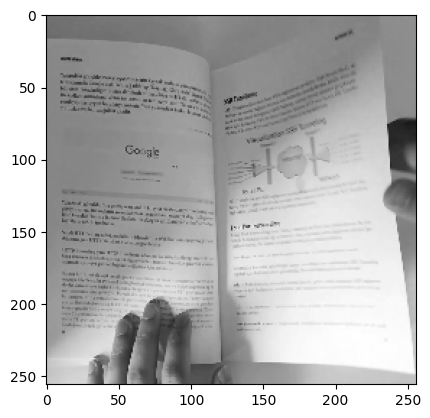

In [ ]:
img_cvt = test_X[10]

plt.imshow(img_cvt, cmap='gray')
plt.show()

Once we create the tensor, we normalize them.
Note that to normalize we divide by 255, since the original values were 8-bits based.

Also note that we perform the normalizatio now, and not when we created the dataset (pickle files) because a float number occupies more memory than a uint8

In [8]:
# transform to torch tensor
training_X = torch.Tensor(training_X)
training_y = torch.Tensor(training_y)
test_X = torch.Tensor(test_X)
test_y = torch.Tensor(test_y)

# perform the normalization
training_X /= 255.0
test_X /= 255.0

# create the datasets as Torch likes them
train_dataset = TensorDataset(training_X, training_y)
test_dataset = TensorDataset(test_X, test_y)

train_data_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Initialization and run

Initialize
- the model
- the loss function: it's a binary classification problem, so we are using the Binary Classification Error loss function
- the optimizer: we could use SGD (I know how it works), but we are going to use Adam, which is the best performing optimizer

In [ ]:
# model = CNN()                     # CPU
# model = CNN().to(device)          # GPU
# model = ShallowCNN().to(device)   # GPU
# model = SmallCNN().to(device)     # GPU
model = MiniCNN().to(device)        # GPU
loss_fn = nn.BCELoss()
opt = Adam(model.parameters(), lr=INIT_LR)

Now we peform the actual training

In [ ]:
# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"train_acc": [],
  "train_precision": [],
  "train_recall": [],
  "train_f1": [],
	"test_loss": [],
	"test_acc": [],
  "test_precision": [],
  "test_recall": [],
  "test_f1": []
}

n_train_sample = training_X.shape[0]
n_test_sample = test_X.shape[0]


# loop over our epochs
for e in range(0, EPOCHS):

  # set the model in training mode -> the computational graphs are saved to be used in backprop
  model.train()

  # initialize the total training and test loss -> it will be used to compute the average epoch values
  total_train_loss = 0
  total_test_loss = 0

  # initialize the number of correct predictions in the training and test step -> used to compute accuracy
  train_correct = 0
  test_correct = 0

  # initialize the count of positive to compute the F1 score
  train_n_true_pos = 0
  train_n_pos = 0
  train_n_gt_pos = 0
  test_n_true_pos = 0
  test_n_pos = 0
  test_n_gt_pos = 0

  # loop over the training set
  for (x, y) in train_data_loader:

    (x, y) = (x.to(device), y.to(device))
    # zero out the gradients
    opt.zero_grad()

    x = torch.reshape(x, (-1, 1, 256, 256))
    # perform a forward pass and calculate the training loss
    pred = model(x)
    pred = torch.reshape(pred, (-1,))
    loss = loss_fn(pred, y)
    # perform the backpropagation step, and update the weights
    loss.backward()
    opt.step()

    # Compute the components for the F1 score
    correct_pred = (torch.round(pred) == y)
    train_n_true_pos += (torch.round(pred[correct_pred]) == 1).type(torch.float).sum().item()  # number of true positive
    train_n_pos += (torch.round(pred) == 1).type(torch.float).sum().item()                     # number of predicted positive
    train_n_gt_pos += (y == 1).type(torch.float).sum().item()                                  # number of expected positive

    n_correct = correct_pred.type(torch.float).sum().item()

    # compute the performance metrics
    total_train_loss += loss
    train_correct += n_correct


  # switch off autograd for evaluation
  with torch.no_grad():

    # set the model in evaluation mode
    model.eval()

    for (x, y) in test_data_loader:

      (x, y) = (x.to(device), y.to(device))

      x = torch.reshape(x, (-1, 1, 256, 256))
      # make the predictions and calculate the validation loss
      pred = model(x)
      pred = torch.reshape(pred, (-1,))

      loss = loss_fn(pred, y)

      # Compute the components for the F1 score
      correct_pred = (torch.round(pred) == y)
      test_n_true_pos += (torch.round(pred[correct_pred]) == 1).type(torch.float).sum().item()  # number of true positive
      test_n_pos += (torch.round(pred) == 1).type(torch.float).sum().item()                     # number of predicted positive
      test_n_gt_pos += (y == 1).type(torch.float).sum().item()                                  # number of expected positive

      n_correct = correct_pred.type(torch.float).sum().item()

      # compute the performance metrics
      total_test_loss += loss
      test_correct += n_correct

  # update our training history
  H["train_loss"].append(total_train_loss.cpu().detach().numpy() / n_train_sample)
  H["train_acc"].append(train_correct / n_train_sample)
  train_prec = train_n_true_pos / train_n_pos
  H["train_precision"].append(train_prec)
  train_recall = train_n_true_pos / train_n_gt_pos
  H["train_recall"].append(train_recall)
  H["train_f1"].append(2*(train_prec * train_recall) / (train_prec + train_recall))

  H["test_loss"].append(total_test_loss.cpu().detach().numpy() / n_test_sample)
  H["test_acc"].append(test_correct / n_test_sample)
  test_prec = test_n_true_pos / test_n_pos
  H["test_precision"].append(test_prec)
  test_recall = test_n_true_pos / test_n_gt_pos
  H["test_recall"].append(test_recall)
  H["test_f1"].append(2*(test_prec * test_recall) / (test_prec + test_recall))

  # print the model training and validation information
  print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
  print("Train loss: {:.4f}, Train correct: {:.2f} %".format(total_train_loss / n_train_sample *100, train_correct / n_train_sample * 100))
  print("Train precision: {:.4f}, Train recall: {:.4f},  Train F1 score: {:.4f}".format(train_prec, train_recall, H["train_f1"][-1]))
  print("Test loss: {:.4f}, Test correct: {:.2f} %".format(total_test_loss / n_test_sample*100, test_correct / n_test_sample* 100))
  print("Test precision: {:.4f}, Test recall: {:.4f},  Test F1 score: {:.4f}\n".format(test_prec, test_recall, H["test_f1"][-1]))


[INFO] EPOCH: 1/15
Train loss: 1.0818, Train correct: 57.15 %
Train precision: 0.6310, Train recall: 0.2840,  Train F1 score: 0.3917
Test loss: 1.0953, Test correct: 75.54 %
Test precision: 0.7835, Test recall: 0.6862,  Test F1 score: 0.7316

[INFO] EPOCH: 2/15
Train loss: 0.9880, Train correct: 72.41 %
Train precision: 0.7515, Train recall: 0.6454,  Train F1 score: 0.6944
Test loss: 0.9569, Test correct: 73.87 %
Test precision: 0.8895, Test recall: 0.5276,  Test F1 score: 0.6623

[INFO] EPOCH: 3/15
Train loss: 0.8780, Train correct: 74.67 %
Train precision: 0.7932, Train recall: 0.6472,  Train F1 score: 0.7128
Test loss: 0.8675, Test correct: 78.22 %
Test precision: 0.7740, Test recall: 0.7793,  Test F1 score: 0.7766

[INFO] EPOCH: 4/15
Train loss: 0.7996, Train correct: 77.55 %
Train precision: 0.8128, Train recall: 0.6988,  Train F1 score: 0.7515
Test loss: 0.7871, Test correct: 79.73 %
Test precision: 0.8596, Test recall: 0.6966,  Test F1 score: 0.7695

[INFO] EPOCH: 5/15
Train los

In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/P4_files/trained_model_mini.pkl')

In [ ]:
with open('/content/gdrive/MyDrive/P4_files/performance_mini.pkl', 'wb') as handle:
  pickle.dump(H, handle, protocol=-1)

# Results

In [ ]:
with open('/content/gdrive/MyDrive/P4_files/performance_mini.pkl', 'rb') as handle:
 perform = pickle.load(handle)

In [ ]:
results = pd.DataFrame(perform)
results['epochs'] = range(1, EPOCHS +1)

In [ ]:
fig = px.line(results, x='epochs', y=['train_loss', 'test_loss'], title='Average Binary Classification Entropy loss')
fig.update_layout(yaxis_range=[0, 0.011])
fig.update_xaxes(dtick=1)

In [ ]:
fig = px.line(results, x='epochs', y=['train_f1', 'test_f1'], title='F1 score')
fig.update_layout(yaxis_range=[0, 1.0])
fig.update_xaxes(dtick=1)

The original CNN is performing slightly better than the shallow one, both in terms of loss/accuracy/F1 and also in terms of computational speed.

Indeed, we removed one convolutional layer, however the output of the convolution is double the size (65536 vs 131072 parameters), hence the fully connected layer is much bigger.

We reduced the size of the shallow CNN (in network called Small CNN) and we notice that the performance are slightly less than the Shallow's (even though are still comparable), but the memory consumption and the computational speed both gained from the size reduction.

The last trial we did is to further reduce the network size, in the network called Mini CNN. We observe lower performance, but still acceptable (test accuracy 88% and F1 89%), but the dimention of the network greatly reduced, as well as the computational time required.

# Sequences - basic approach

The basic approach to work with sequences is to analyze each frame independently; then, we consider all the outputs from the individual frame to compute the final output of the model.

Since we are considering each frame individually, we can reuse the already trained models.

We are going to maintain the separation between train and test because it is going to be useful at later stages.

But first, we need to load and prepare the data for torch

In [2]:
import torch

note that in this case the batches are the sequences themselves:
we do not need a batch size, nor we need the data loader.

Note that the data currently are not shuffled, but since we are not performing training but just inference, this is not a problem

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
with open('/content/gdrive/MyDrive/P4_files/training_sequ.pkl', 'rb') as handle:
  training_X = pickle.load(handle)

with open('/content/gdrive/MyDrive/P4_files/training_sequ_labels.pkl', 'rb') as handle:
  training_y = pickle.load(handle)

with open('/content/gdrive/MyDrive/P4_files/test_sequ.pkl', 'rb') as handle:
  test_X = pickle.load(handle)

with open('/content/gdrive/MyDrive/P4_files/test_sequ_labels.pkl', 'rb') as handle:
  test_y = pickle.load(handle)

In [21]:
print(training_y)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]


In [24]:
# Create the training set as a iterable collection of sequences + corresponding label
# Note that at this stage we perform the conversion to Tensor, and we also normalize the images
train_dataset = []

for idx, sequ in enumerate(training_X):
  tmp_x = torch.Tensor(sequ) / 255.0
  train_dataset.append((tmp_x, training_y[idx]))

In [6]:
# Create the training set as a iterable collection of sequences + corresponding label
# Note that at this stage we perform the conversion to Tensor, and we also normalize the images
test_dataset = []

for idx, sequ in enumerate(test_X):
  tmp_x = torch.Tensor(sequ) / 255.0
  tmp_y = torch.Tensor(test_y[idx])
  test_dataset.append((tmp_x, tmp_y))

Let's initialize the model and load the state dictionary from the saved file


In [11]:
model = CNN().to(device)          # GPU
# model = SmallCNN().to(device)     # GPU

In [12]:
model.load_state_dict(torch.load('/content/gdrive/MyDrive/P4_files/trained_model.pkl'))

<All keys matched successfully>

Since we are working with sequences rather then single frames, we need to add an extra step: we need to merge all the frames predictions in one sequence prediction. We try two different approaches:
- We **average** the frames prediction
- We **max pool** the frames rounded predictions

In [31]:
# as score measure we compute the Confusion Matrix
# Note - it will be read:
#     pred
# t
# r
# u
# e
avg_conf_matrix = np.zeros((2,2))
pool_conf_matrix = np.zeros((2,2))

# loop over the training set
for (x, y) in train_dataset:

  (x, y) = (x.to(device), y)
  x = torch.reshape(x, (-1, 1, 256, 256))
  # perform a forward pass and calculate the training loss
  pred = model(x)
  pred = torch.reshape(pred, (-1,))

  # now we need to aggregate together the predictions
  avg_pred = torch.round(torch.mean(pred)).item()

  # do max pooling
  pos_frames = torch.round(pred).sum()

  if pos_frames >= pred.shape[0] - pos_frames:
    pool_pred = 1
  else:
    pool_pred = 0

  # Increase the score counts
  avg_conf_matrix[y][int(avg_pred)] += 1
  pool_conf_matrix[y][int(pool_pred)] += 1

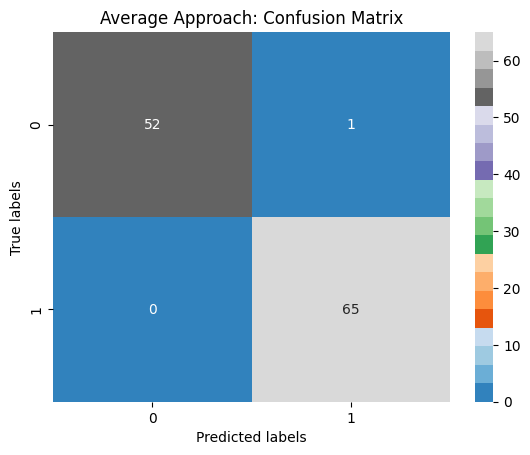

In [32]:
import seaborn as sns

ax= plt.subplot()
sns.heatmap(avg_conf_matrix, cmap='tab20c', annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Average Approach: Confusion Matrix');

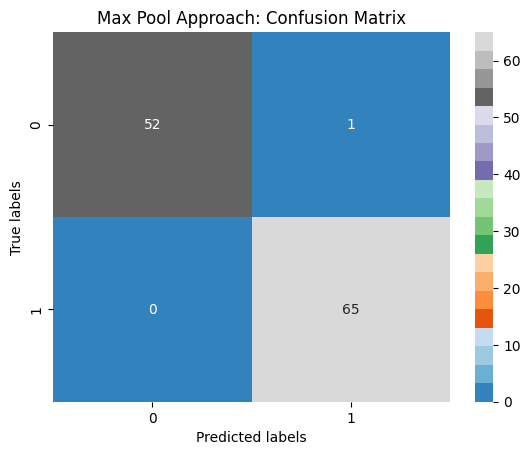

In [33]:
ax= plt.subplot()
sns.heatmap(pool_conf_matrix, cmap='tab20c', annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Max Pool Approach: Confusion Matrix');